# target encoder & ohe & just dcn

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, dcn, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [5]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:10, 54893.31it/s]


In [6]:
ecd.fit(test_df, verbose=1)

400000it [00:07, 55839.43it/s]


In [7]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:12, 46917.75it/s]
400000it [00:08, 47796.81it/s]


# Search Max LR

In [8]:
%%time
%matplotlib inline

mf = {}
for num in [1,2,3,4]:
    batch_size = 8192
    epochs = 5
    nflold = 5

    model_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam',
                   'loss': 'binary_crossentropy',
                   'num_cross': num,
                   'use_linear':False}

    mf[num] = MaxLrFinder(1e-5, 1e-1, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
    fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf[num]]}

    model = dcn(**model_param)

    cv = CV(model, nflold)

    score = cv.fit(x=[idx, val],
                   y=y_train, 
                   metrics_func=roc_auc_score,
                   split_method=StratifiedKFold,
                   fit_params=fit_param,
                   eval_param={'batch_size':batch_size},
                   use_proba=False, 
                   verbose=True,
                   fit_use_valid=True)

    tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/5
480000/480000 [==============================] - 6s 13us/sample - loss: 0.9151 - AUC: 0.5094 - val_loss: 0.7074 - val_AUC: 0.5322
Epoch 2/5
480000/480000 [==============================] - 4s 9us/sample - loss: 0.7553 - AUC: 0.5927 - val_loss: 0.6251 - val_AUC: 0.5998
Epoch 3/5
480000/480000 [==============================] - 4s 9us/sample - loss: 0.4634 - AUC: 0.7013 - val_loss: 0.4668 - val_AUC: 0.7393
Epoch 4/5
480000/480000 [==============================] - 4s 9us/sample - loss: 0.4022 - AUC: 0.7787 - val_loss: 0.4366 - val_AUC: 0.7688
Epoch 5/5
480000/480000 [==============================] - 4s 9us/sample - loss: 0.3995 - AUC: 0.7828 - val_loss: 0.4974 - val_AUC: 0.7743
folds 0 is done, score is 0.7745011785461433
Train on 480000 samples, validate on 120000 samples
Epoch 1/5
480000/480000 [==============================] - 6s 12us/sample - loss: 0.8714 - AUC: 0.5360 - val_loss: 0.6819 - val_AUC: 0.5553
Epoch 2/5
48000

480000/480000 [==============================] - 7s 14us/sample - loss: 0.5155 - AUC: 0.6011 - val_loss: 0.5258 - val_AUC: 0.6394
Epoch 3/5
480000/480000 [==============================] - 7s 14us/sample - loss: 0.4230 - AUC: 0.7427 - val_loss: 0.4644 - val_AUC: 0.7563
Epoch 4/5
480000/480000 [==============================] - 7s 14us/sample - loss: 0.4012 - AUC: 0.7803 - val_loss: 0.4288 - val_AUC: 0.7747
Epoch 5/5
480000/480000 [==============================] - 7s 15us/sample - loss: 0.3997 - AUC: 0.7829 - val_loss: 0.4772 - val_AUC: 0.7778
folds 0 is done, score is 0.7779049511260886
Train on 480000 samples, validate on 120000 samples
Epoch 1/5
480000/480000 [==============================] - 9s 18us/sample - loss: 0.5742 - AUC: 0.5366 - val_loss: 0.6083 - val_AUC: 0.5534
Epoch 2/5
480000/480000 [==============================] - 7s 15us/sample - loss: 0.4655 - AUC: 0.6685 - val_loss: 0.4907 - val_AUC: 0.7056
Epoch 3/5
480000/480000 [==============================] - 7s 14us/sample

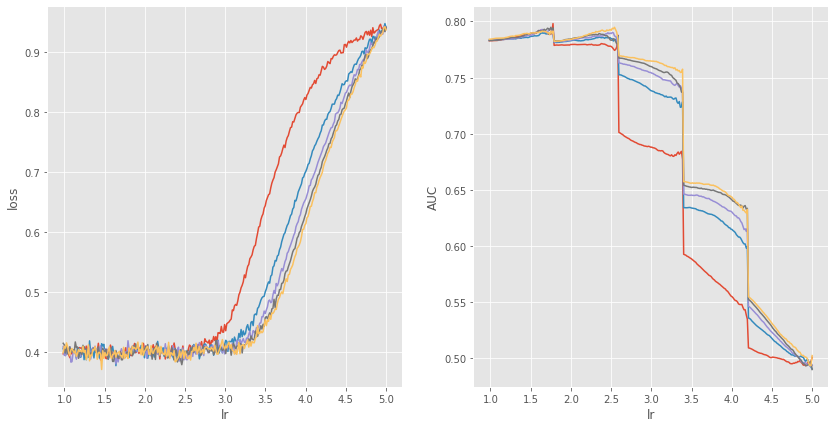

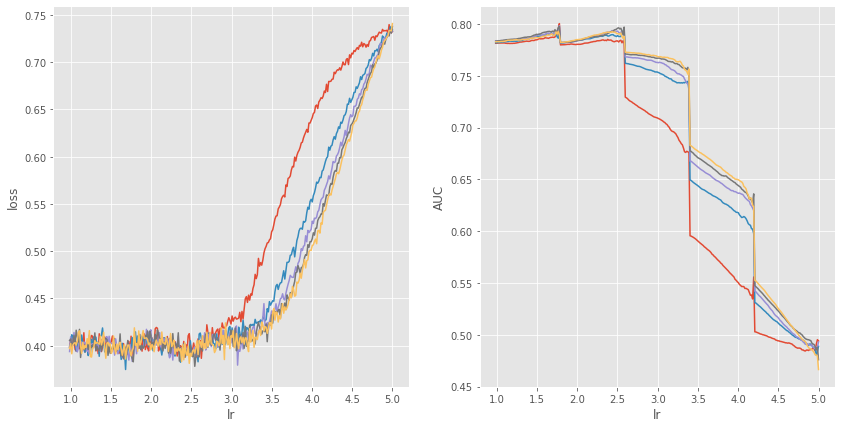

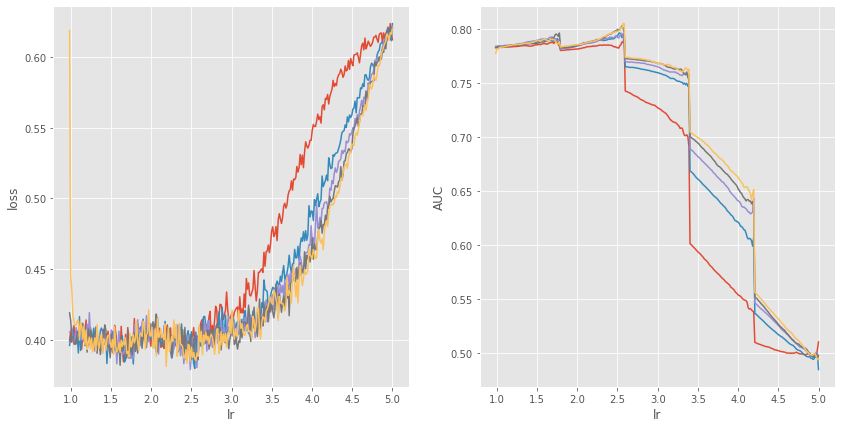

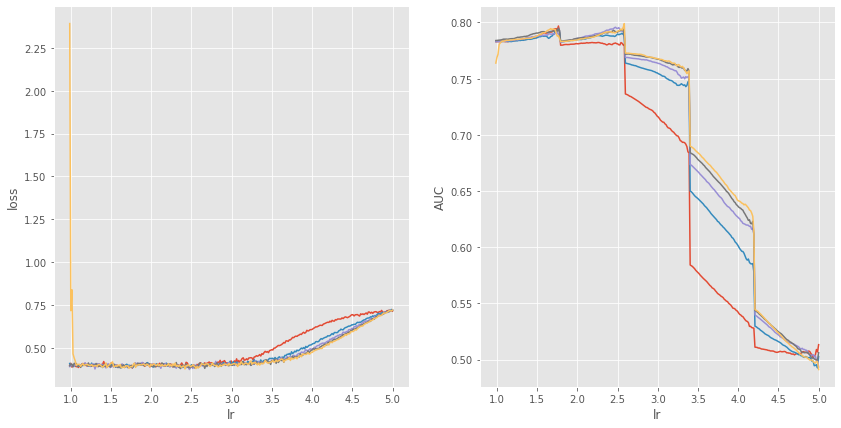

In [9]:
%matplotlib inline
for key, submf in mf.items():
    submf.plot(True)

# fit one

In [12]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy',
               'use_linear': False,
               'k': 10,
               'num_cross': 4,
               'deep_use_bias': True, 
               'num_deep_layer': 4, 
               'num_neuron': 256}

clr = CyclicLR(base_lr=1e-4,
               max_lr = 0.1**(2.5), 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = dcn(**model_param)

cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/100
480000/480000 [==============================] - 19s 39us/sample - loss: 0.5299 - AUC: 0.6250 - val_loss: 0.4947 - val_AUC: 0.6571
Epoch 2/100
480000/480000 [==============================] - 16s 34us/sample - loss: 0.4038 - AUC: 0.7764 - val_loss: 0.4764 - val_AUC: 0.7270
Epoch 3/100
480000/480000 [==============================] - 16s 34us/sample - loss: 0.3885 - AUC: 0.7992 - val_loss: 0.4671 - val_AUC: 0.7501
Epoch 4/100
480000/480000 [==============================] - 16s 34us/sample - loss: 0.3810 - AUC: 0.8096 - val_loss: 0.4532 - val_AUC: 0.7562
Epoch 5/100
480000/480000 [==============================] - 16s 34us/sample - loss: 0.3697 - AUC: 0.8242 - val_loss: 0.4541 - val_AUC: 0.7420
Epoch 6/100
480000/480000 [==============================] - 16s 34us/sample - loss: 0.3450 - AUC: 0.8533 - val_loss: 0.4460 - val_AUC: 0.7209
Epoch 7/100
480000/480000 [==============================] - 17s 35us/sample - loss: 0.313

In [13]:
score

0.7684684007146181

# Tuning

In [14]:
%matplotlib qt5

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=1e-4,
               max_lr = 0.1**(2.5),
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear':False}

ss = {
    'loss': (hp.choice, ('binary_crossentropy', 'focal_loss')), 
    'k': (hp.choice, (5, 7, 8, 10)),
    'num_cross': (hp.choice, (1, 2, 3 ,4)),
    'l2_em': (hp.loguniform, (-15, -5)),
    'l2_cross': (hp.loguniform, (-20, 0)),
    'l2_deep': (hp.loguniform, (-15, -5)),
    'deep_dropout': (hp.uniform, (0, 0.5)), 
    'deep_use_bias': (hp.choice, (True, False)), 
    'num_deep_layer': (hp.choice, (1,2,3,4)), 
    'num_neuron': (hp.choice, (64, 128, 256)), 
    'deep_activation': (hp.choice, ('mish', 'gelu'))
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=dcn, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7857, param {'deep_activation': 'gelu', 'deep_dropout': 0.2779240898410794, 'deep_use_bias': False, 'k': 8, 'l2_cross': 2.591376642138009e-09, 'l2_deep': 2.4451603110988297e-06, 'l2_em': 0.0033426227465474497, 'loss': 'focal_loss', 'num_cross': 1, 'num_deep_layer': 2, 'num_neuron': 256}
new best, eval 2, score -0.7866, param {'deep_activation': 'gelu', 'deep_dropout': 0.24422688911627816, 'deep_use_bias': False, 'k': 5, 'l2_cross': 3.4839272877471195e-08, 'l2_deep': 0.004230079938585754, 'l2_em': 5.739843154982707e-06, 'loss': 'focal_loss', 'num_cross': 3, 'num_deep_layer': 3, 'num_neuron': 64}
new best, eval 4, score -0.7871, param {'deep_activation': 'mish', 'deep_dropout': 0.12168517905155068, 'deep_use_bias': False, 'k': 8, 'l2_cross': 0.00012694393928178573, 'l2_deep': 0.0011939981235729255, 'l2_em': 0.0004522727079338056, 'loss': 'focal_loss', 'num_cross': 1, 'num_deep_layer': 4, 'num_neuron': 64}
new best, eval 5, score -0.7871, param {'deep_activation

{'deep_activation': 0,
 'deep_dropout': 0.4286285856229364,
 'deep_use_bias': 1,
 'k': 2,
 'l2_cross': 0.0008655972852635071,
 'l2_deep': 6.611848944719447e-06,
 'l2_em': 0.00570216632684591,
 'loss': 0,
 'num_cross': 1,
 'num_deep_layer': 3,
 'num_neuron': 2}

In [15]:
log = tuning.log.get_log()

In [16]:
log.sort_values('score').head(20)

,score,update,usetime,deep_activation,deep_dropout,deep_use_bias,k,l2_cross,l2_deep,l2_em,loss,num_cross,num_deep_layer,num_neuron
85,-0.788592,True,821.496219,mish,0.428629,False,8,8.655973e-04,6.611849e-06,0.005702,binary_crossentropy,2,4,256
97,-0.788465,False,760.194015,mish,0.420516,False,8,3.066037e-03,8.825203e-05,0.003745,focal_loss,2,1,256
92,-0.788395,False,804.650155,mish,0.456128,False,8,3.243555e-02,3.465316e-05,0.006144,focal_loss,2,1,256
33,-0.788375,True,455.435780,mish,0.429841,True,5,1.748657e-01,3.108811e-07,0.005656,binary_crossentropy,2,4,64
68,-0.788339,False,608.786331,mish,0.480129,False,10,4.626274e-04,8.731448e-07,0.004539,binary_crossentropy,2,4,64
42,-0.788294,False,1067.331488,gelu,0.418485,False,7,6.372103e-05,4.912918e-07,0.003261,binary_crossentropy,2,4,256
37,-0.788282,False,544.321674,mish,0.399775,False,10,1.605633e-05,5.707335e-07,0.003792,binary_crossentropy,2,4,64
76,-0.788275,False,679.793449,mish,0.369787,True,5,8.877544e-06,1.401114e-06,0.001827,binary_crossentropy,2,4,128
79,-0.788268,False,824.489878,gelu,0.311908,True,10,4.445481e-07,2.890579e-05,0.003024,binary_crossentropy,1,4,256
70,-0.788248,False,561.040866,mish,0.464747,False,10,7.192272e-04,1.890302e-06,0.001579,binary_crossentropy,2,4,64


In [17]:
log.sort_values('score').tail(20)

,score,update,usetime,deep_activation,deep_dropout,deep_use_bias,k,l2_cross,l2_deep,l2_em,loss,num_cross,num_deep_layer,num_neuron
23,-0.786158,False,233.365691,mish,0.010848,True,7,4.037781e-04,7.960734e-05,1.259367e-04,binary_crossentropy,1,1,64
51,-0.786142,False,1361.097713,gelu,0.216570,False,8,1.549254e-06,1.041798e-06,1.975732e-05,binary_crossentropy,2,4,256
52,-0.786139,False,3250.992541,gelu,0.499565,True,7,6.923560e-04,1.155846e-05,5.221735e-06,focal_loss,2,4,256
78,-0.786122,False,790.829827,mish,0.039898,False,7,1.719624e-03,6.670618e-04,3.626820e-04,focal_loss,4,2,64
53,-0.786105,False,1050.588333,gelu,0.381303,True,5,1.454335e-01,5.027572e-07,4.352945e-04,binary_crossentropy,2,2,256
60,-0.786101,False,1198.695446,mish,0.237661,True,5,2.794692e-07,1.663922e-04,4.197210e-06,binary_crossentropy,2,4,256
59,-0.786058,False,581.198673,gelu,0.096959,False,8,3.776061e-03,7.224619e-07,2.046626e-03,binary_crossentropy,3,4,64
95,-0.785817,False,1370.342346,mish,0.463029,True,8,2.411836e-01,3.962944e-04,6.669836e-03,focal_loss,2,1,256
17,-0.785807,False,1100.212027,mish,0.253606,False,10,1.272019e-08,6.542610e-07,3.503650e-05,focal_loss,4,1,256
0,-0.785656,True,701.948554,gelu,0.277924,False,8,2.591377e-09,2.445160e-06,3.342623e-03,focal_loss,1,2,256


[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]


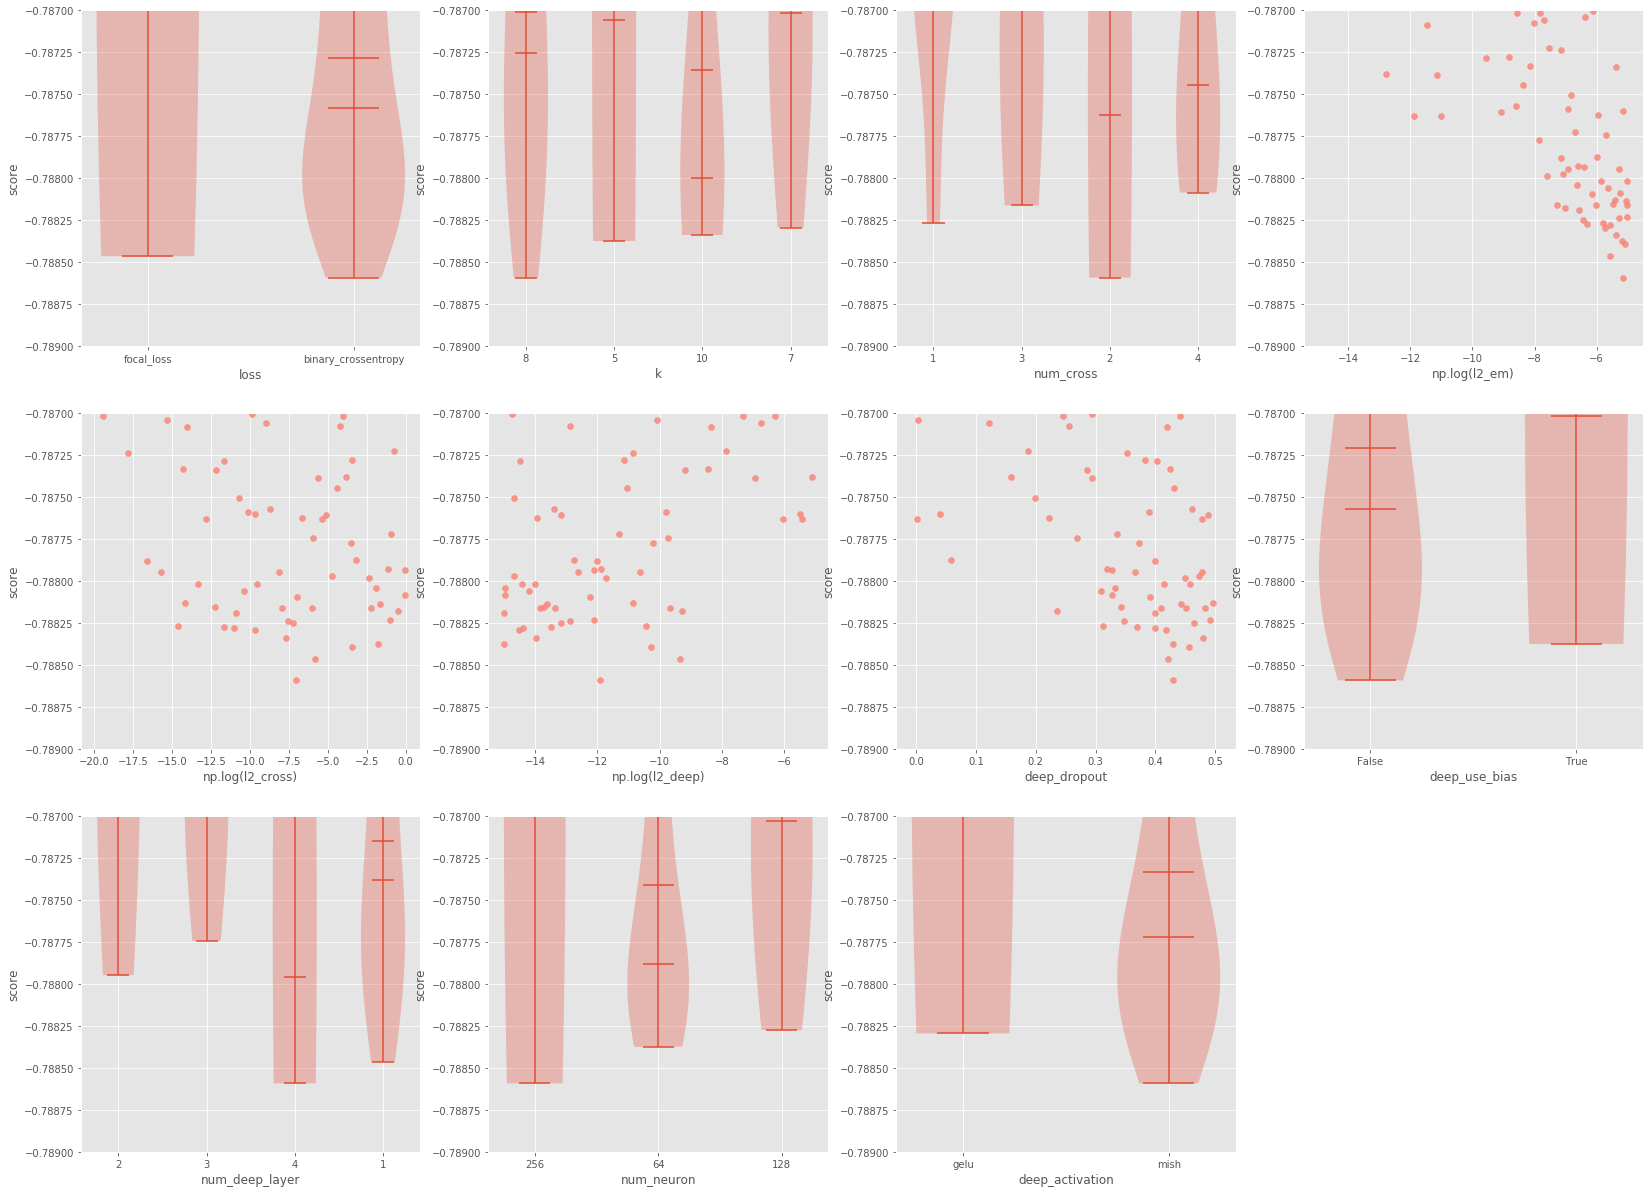

In [18]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.789, -0.787])

In [ ]:
np.random.randint(2**32)

### 2072349059

In [ ]:
! mkdir ../tmp/cross

In [ ]:
log.to_csv('../tmp/cross/2072349059.csv', index=False)

In [ ]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 5

In [ ]:
# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False, 
                   'use_deep': False}

In [ ]:
# callbacks
clr = CyclicLR(
    base_lr=1e-4,
    max_lr = 0.1**(2.5), 
    step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

# Stacking 1

In [ ]:
pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = {}
    for param_name, param_value in model_fix_param.items():
        model_params[param_name] = param_value
        
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = dcn(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=[idx, val],
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=[idx_test, val_test], pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    tf.keras.backend.clear_session()

In [ ]:
pred_arr = np.array(pred_arr_lst).squeeze().T
np.save('../tmp/cross/2072349059stacking1.npy', pred_arr)
pred_arr.shape

In [ ]:
pred = np.array(pred_lst).squeeze().T
np.save('../tmp/cross/2072349059predict.npy', pred)
pred.shape

In [ ]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = np.mean(pred_lst, axis=0)
submission.to_csv('../tmp/submission/main_5_crossnet_2072349059.csv')